In [1]:
import os
import sys

In [2]:
sys.path.insert(0, '/Users/marusy/Programming/another-fem-framework/')
#sys.path.insert(0, '/home/lshtanko/Programming/another-fem-framework/')

In [3]:
import numpy as np
from interpolant.cell_to_points import Cell2PointsConverter
from interpolant.strict import StrictSolve
from interpolant.opt import OptSolve
from common.helpers import *
from interpolant.helpers import *
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
c2p = Cell2PointsConverter(orders=[[3],[3,3]])

In [34]:
strict_solve = StrictSolve(points=c2p.get_points(), weights=c2p.get_diag_weights(), verbose=True)

In [35]:
strict_solve.fit_strict(max_power=strict_solve.get_max_pow(unrisky=True), method='sympy')

Number of equations: 11
Number of degrees of freedom: 28
Strictly stitched_power: 0
Start solving strict part
End solving strict part
NullspaceRank: 18


In [36]:
interps = strict_solve.get_interpolants()
wgths = strict_solve.get_weight_matrices()

In [37]:
opt_solve = OptSolve(matrices=interps,
                     points=c2p.get_points(),
                     strict_power=strict_solve.get_max_pow(unrisky=True),
                     weights_matrices=wgths,
                     verbose=True
                    )

In [38]:
opt_solve.fit_opt(constraints=True, tr_fun_option='chebyshev', orders_forwards=1)

In [23]:
opt_solve.restart_opt(tolerance=1e-3)

In [39]:
I_rl = np.array(opt_solve.I_rl_subbed).astype(np.float64)
I_lr = np.array(opt_solve.I_lr_subbed).astype(np.float64)

In [28]:
tr_f = np.vectorize(lambda x: (x-0.5)*x)

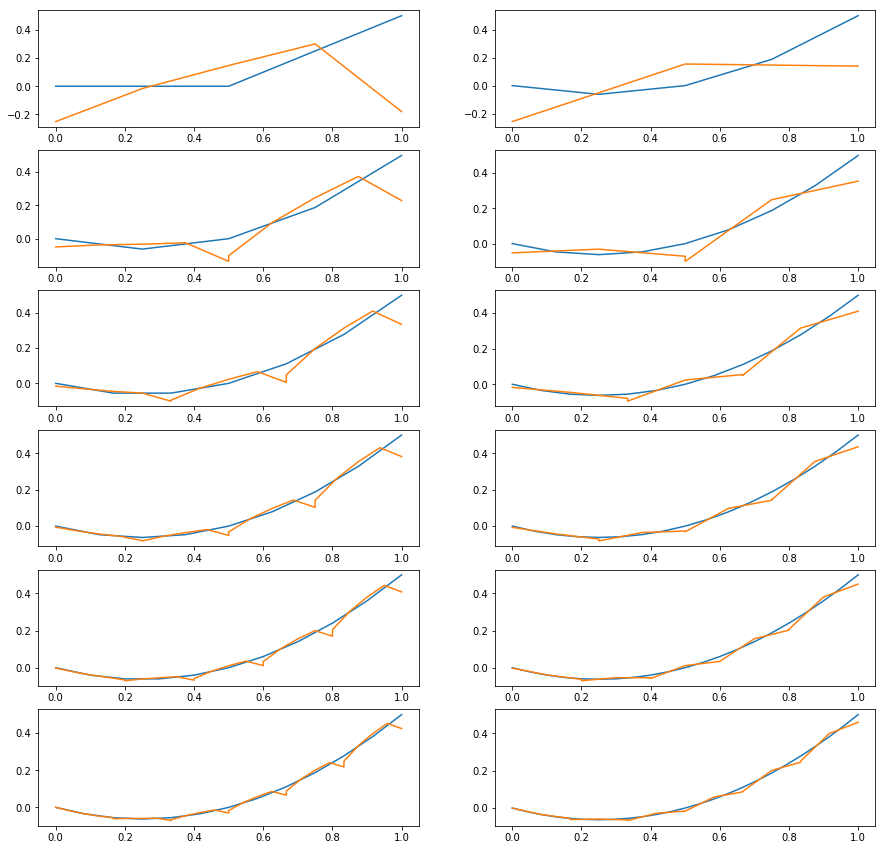

In [29]:
eps_l, eps_r = convergence_test(I_lr=I_lr,
                                I_rl=I_rl,
                                p_l=opt_solve.points[0],
                                p_r=opt_solve.points[1],
                                init_size=(0,1),
                                tr_f=tr_f,
                                weights=[np.array(strict_solve.W_l), np.array(strict_solve.W_r)],
                                div_lim=7)

In [ ]:
explosion_test(I_lr=I_lr,
               I_rl=I_rl,
               p_l=opt_solve.points[0],
               p_r=opt_solve.points[1],
               tr_f=tr_f,
               reps=3)

In [ ]:
plt.semilogy(range(len(eps_l)), eps_l)
plt.semilogy(range(len(eps_r)), eps_r)
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-np.linspace(0, len(eps_r))))
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-2*np.linspace(0, len(eps_r))))

In [40]:
np.linalg.eigvals(np.dot(I_lr, I_rl))

array([  6.27025081e-01 +0.00000000e+00j,
         9.99678232e-01 +0.00000000e+00j,
         9.99999705e-01 +0.00000000e+00j,
         1.00000000e+00 +0.00000000e+00j,
         6.36913485e-17 +0.00000000e+00j,
        -3.58302997e-17 +4.45273034e-17j,  -3.58302997e-17 -4.45273034e-17j])

In [41]:
I_lr

array([[ 0.94748435,  0.08218652,  0.00679549, -0.03646636],
       [ 0.31304669,  0.81263552, -0.09974331, -0.02593889],
       [-0.12478712,  1.00624854,  0.11348253,  0.00505606],
       [ 0.22008957,  0.05460024,  0.68518757,  0.04012262],
       [-0.01387373,  0.20320454,  0.7569224 ,  0.05374679],
       [-0.06389369, -0.06951784,  1.05398856,  0.07942297],
       [ 0.0598758 ,  0.04575923, -0.50042152,  1.39478649]])

In [42]:
I_rl

array([[  4.73742176e-01,   7.82616722e-01,  -3.11967812e-01,
          2.20089572e-01,  -3.46843350e-02,  -1.59734222e-01,
          2.99378982e-02],
       [  8.21865191e-03,   4.06317760e-01,   5.03124268e-01,
          1.09200474e-02,   1.01602272e-01,  -3.47589224e-02,
          4.57592318e-03],
       [  6.79548951e-04,  -4.98716573e-02,   5.67412656e-02,
          1.37037514e-01,   3.78461201e-01,   5.26994280e-01,
         -5.00421522e-02],
       [ -1.82331802e-02,  -6.48472355e-02,   1.26401418e-02,
          4.01226215e-02,   1.34366971e-01,   1.98557435e-01,
          6.97393247e-01]])

In [ ]:
np.dot(I_lr, c2p.get_weights()[0]).sum()

In [ ]:
c2p.get_weights()[0]

In [ ]:
np.dot(I_rl, c2p.get_weights()[1]).sum()

In [ ]:
np.dot(np.dot(c2p.get_diag_weights()[1], I_lr), np.linalg.inv(c2p.get_diag_weights()[0]))

In [ ]:
I_rl.T